# **Indian Pines**

**Base FS**

✅ Model successfully loaded on cuda
✅ Feature extraction complete. Shape: (21025, 128)
✅ Computing lacunarity for box size 2...
✅ Computing lacunarity for box size 4...
✅ Computing lacunarity for box size 8...
✅ Computing lacunarity for box size 16...
✅ Computing lacunarity for box size 32...
   Box Size  Class Prototypes
0         2      17616.628906
1         4      17527.205078
2         8     173643.828125
3        16      61809.667969
4        32      25687.328125


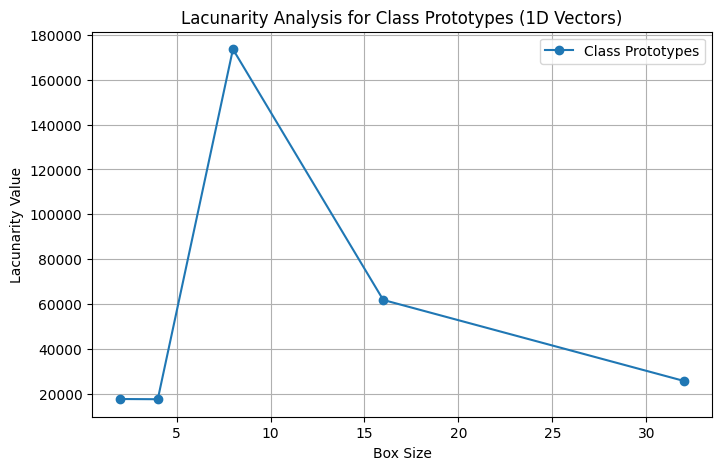

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import time
import os

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0 or var == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# ✅ Start Timer for Computational Efficiency
start_time = time.time()

# --------------------------------------------
# ✅ Spectral Feature Extractor (1D CNN)
# --------------------------------------------
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 200, 128)  # Flattened feature output

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 200) -> (batch, 1, 200)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# ✅ Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        query_embeddings = query_embeddings.view(-1, prototypes.shape[-1])
        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2
        return -dists

# ✅ Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "PrototypicalNetwork_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

print(f"✅ Model successfully loaded on {device}")

# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# ✅ Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# ✅ Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# ✅ Extract Features using the trained model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()  # Convert to NumPy for classification

print("✅ Feature extraction complete. Shape:", embeddings.shape)  # Should be (22213, 128)

# ✅ Compute class prototypes (mean embeddings per class)
class_prototypes = {}
for cls in np.unique(y):
    class_indices = np.where(y == cls)[0]
    class_prototypes[cls] = embeddings[class_indices].mean(axis=0)

# ✅ Convert prototypes to tensor
prototype_array_np = np.array(list(class_prototypes.values()))  # Shape: (num_classes, 128)

# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
max_box_size = prototype_array_np.shape[1] // 2
box_sizes = [2, 4, 8, 16, 32]  # Fixed sizes
box_sizes = [b for b in box_sizes if b <= max_box_size]  # Filter valid box sizes

lacunarity_results = {"Box Size": [], "Class Prototypes": []}

# ✅ Loop through box sizes for lacunarity calculation
for box_size in box_sizes:
    print(f"✅ Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes directly as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array_np, box_size))

        # ✅ Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for Class Prototypes (1D Vectors)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")

**Aug FS**

Model successfully loaded on cuda
✅ Feature extraction complete. Shape: (21025, 256)
✅ Computing lacunarity for box size 2...
✅ Computing lacunarity for box size 4...
✅ Computing lacunarity for box size 8...
✅ Computing lacunarity for box size 16...
✅ Computing lacunarity for box size 32...
   Box Size  Class Prototypes
0         2      2.372657e+04
1         4      2.490509e+03
2         8      8.129671e+05
3        16      1.170535e+05
4        32      2.240272e+07


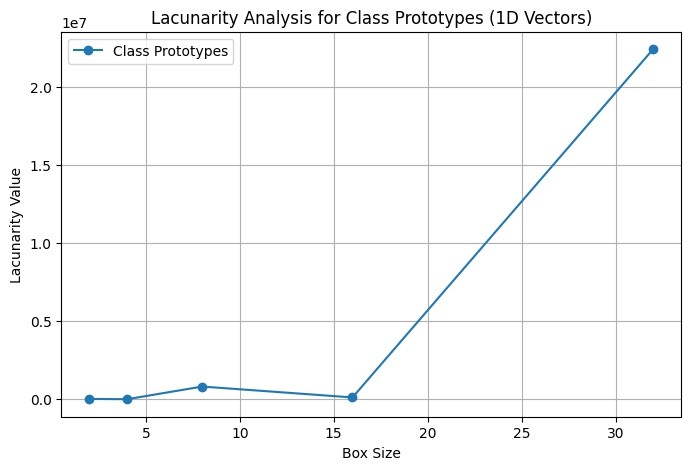

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import time
import os

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0 or var == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# ✅ Start Timer for Computational Efficiency
start_time = time.time()

# --------------------------------------------
# ✅ Spectral Feature Extractor (1D CNN)
# --------------------------------------------
# Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128 * input_dim, 256)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, input_dim):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor(input_dim)

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "Augmented_PrototypicalNetwork_IP.pth")

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Determine input dimension dynamically
input_dim = df_spectral.shape[1] - 1  # Exclude class column

# Initialize the model
model = PrototypicalNetwork(input_dim).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

print(f"Model successfully loaded on {device}")

# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# ✅ Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# ✅ Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# ✅ Extract Features using the trained model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()  # Convert to NumPy for classification

print("✅ Feature extraction complete. Shape:", embeddings.shape)  # Should be (22213, 128)

# ✅ Compute class prototypes (mean embeddings per class)
class_prototypes = {}
for cls in np.unique(y):
    class_indices = np.where(y == cls)[0]
    class_prototypes[cls] = embeddings[class_indices].mean(axis=0)

# ✅ Convert prototypes to tensor
prototype_array_np = np.array(list(class_prototypes.values()))  # Shape: (num_classes, 128)

# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
max_box_size = prototype_array_np.shape[1] // 2
box_sizes = [2, 4, 8, 16, 32]  # Fixed sizes
box_sizes = [b for b in box_sizes if b <= max_box_size]  # Filter valid box sizes

lacunarity_results = {"Box Size": [], "Class Prototypes": []}

# ✅ Loop through box sizes for lacunarity calculation
for box_size in box_sizes:
    print(f"✅ Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes directly as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array_np, box_size))

        # ✅ Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for Class Prototypes (1D Vectors)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")

**CAT-FSL**

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 104.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
!pip install numpy --upgrade
!pip install catboost --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 105.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89

✅ Model successfully loaded on cuda
✅ Feature extraction complete. Shape: (21025, 256)
0:	learn: 2.6104305	total: 13.6ms	remaining: 13.5s
50:	learn: 0.8606865	total: 526ms	remaining: 9.79s
100:	learn: 0.6224075	total: 1.02s	remaining: 9.05s
150:	learn: 0.5373952	total: 1.51s	remaining: 8.48s
200:	learn: 0.4972338	total: 2s	remaining: 7.95s
250:	learn: 0.4722195	total: 2.48s	remaining: 7.41s
300:	learn: 0.4535490	total: 2.96s	remaining: 6.87s
350:	learn: 0.4378320	total: 3.44s	remaining: 6.36s
400:	learn: 0.4250301	total: 3.91s	remaining: 5.84s
450:	learn: 0.4132478	total: 4.39s	remaining: 5.35s
500:	learn: 0.4026350	total: 4.87s	remaining: 4.85s
550:	learn: 0.3925988	total: 5.35s	remaining: 4.36s
600:	learn: 0.3835129	total: 5.82s	remaining: 3.86s
650:	learn: 0.3749525	total: 6.3s	remaining: 3.38s
700:	learn: 0.3667395	total: 6.77s	remaining: 2.89s
750:	learn: 0.3588779	total: 7.24s	remaining: 2.4s
800:	learn: 0.3513993	total: 7.72s	remaining: 1.92s
850:	learn: 0.3443479	total: 8.19s	r

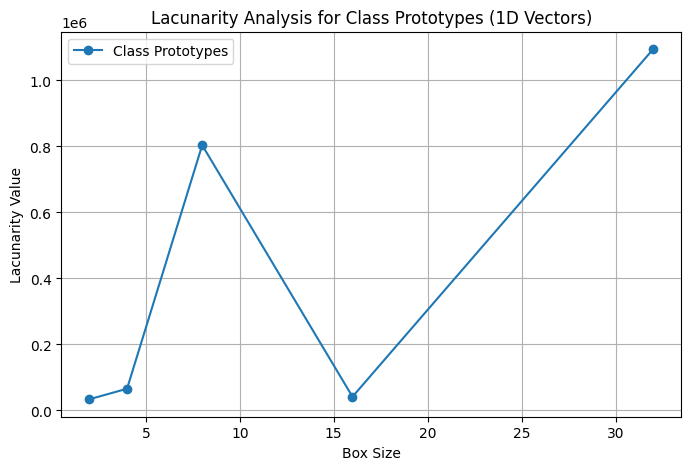

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import time
import os
from catboost import CatBoostClassifier

# ✅ Define device for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0 or var == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# ✅ Start Timer for Computational Efficiency
start_time = time.time()

# --------------------------------------------
# ✅ Spectral Feature Extractor (1D CNN)
# --------------------------------------------
# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 200  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print(f"✅ Model successfully loaded on {device}")


# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# ✅ Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# ✅ Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Convert to Tensor (Fixing Shape)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)  # Shape: (batch, 204)

# ✅ Fix: Reshape to match Conv1d input (batch, channels, spectral bands)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)  # Shape → (batch, 204, 1)

# ✅ Extract Features using Trained Model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()  # ✅ Convert to NumPy for CatBoost

print("✅ Feature extraction complete. Shape:", deep_features.shape)  # ✅ Correct variable name

# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)

catboost_model.fit(deep_features, y, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

# ✅ Compute Class Prototypes
unique_classes = np.unique(y)
class_prototypes = {}

for cls in unique_classes:
    cls_indices = np.where(y == cls)[0]
    cls_features = deep_features[cls_indices]  # ✅ Correct array indexing
    class_prototypes[cls] = np.mean(cls_features, axis=0)  # ✅ Compute mean feature for each class

# ✅ Convert Class Prototypes to Tensor
prototype_array_np = torch.tensor(np.array(list(class_prototypes.values())), dtype=torch.float32, device=device)

# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
max_box_size = prototype_array_np.shape[1] // 2
box_sizes = [2, 4, 8, 16, 32]  # Fixed sizes
box_sizes = [b for b in box_sizes if b <= max_box_size]  # Filter valid box sizes

lacunarity_results = {"Box Size": [], "Class Prototypes": []}

# ✅ Loop through box sizes for lacunarity calculation
for box_size in box_sizes:
    print(f"✅ Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes directly as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array_np.cpu().numpy(), box_size))

        # ✅ Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for Class Prototypes (1D Vectors)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")

# **SALINAS**

**Base FS**

✅ Model successfully loaded on cuda
✅ Feature extraction complete. Shape: (22213, 128)
✅ Computing lacunarity for box size 2...
✅ Computing lacunarity for box size 4...
✅ Computing lacunarity for box size 8...
✅ Computing lacunarity for box size 16...
✅ Computing lacunarity for box size 32...
   Box Size  Class Prototypes
0         2      2.260430e+03
1         4      4.172273e+05
2         8      1.336921e+06
3        16      4.711640e+04
4        32      5.001189e+05


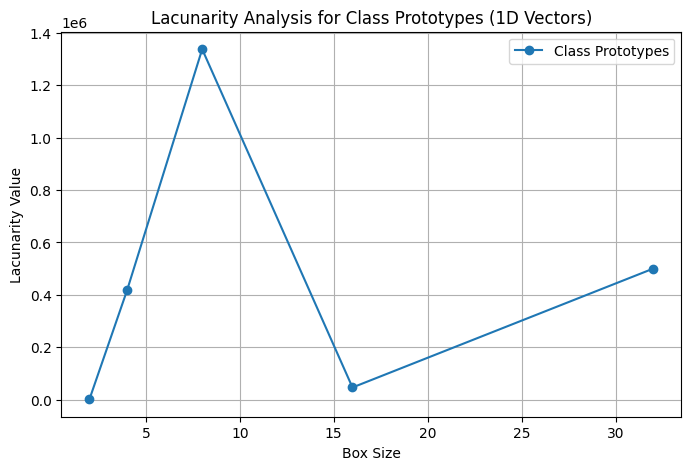

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import time
import os

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0 or var == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# ✅ Start Timer for Computational Efficiency
start_time = time.time()

# --------------------------------------------
# ✅ Spectral Feature Extractor (1D CNN)
# --------------------------------------------
# Define Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 204, 128)  # 204 spectral bands

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 204) -> (batch, 1, 204)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Define Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "PrototypicalNetwork_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

print(f"✅ Model successfully loaded on {device}")

# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -4].values  # Last column as true class labels

# ✅ Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# ✅ Extract Features using the trained model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()  # Convert to NumPy for classification

print("✅ Feature extraction complete. Shape:", embeddings.shape)  # Should be (22213, 128)

# ✅ Compute class prototypes (mean embeddings per class)
class_prototypes = {}
for cls in np.unique(y):
    class_indices = np.where(y == cls)[0]
    class_prototypes[cls] = embeddings[class_indices].mean(axis=0)

# ✅ Convert prototypes to tensor
prototype_array_np = np.array(list(class_prototypes.values()))  # Shape: (num_classes, 128)

# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
max_box_size = prototype_array_np.shape[1] // 2
box_sizes = [2, 4, 8, 16, 32]  # Fixed sizes
box_sizes = [b for b in box_sizes if b <= max_box_size]  # Filter valid box sizes

lacunarity_results = {"Box Size": [], "Class Prototypes": []}

# ✅ Loop through box sizes for lacunarity calculation
for box_size in box_sizes:
    print(f"✅ Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes directly as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array_np, box_size))

        # ✅ Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for Class Prototypes (1D Vectors)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")

**Aug FS**

Model successfully loaded on cuda
✅ Feature extraction complete. Shape: (22213, 256)
✅ Computing lacunarity for box size 2...
✅ Computing lacunarity for box size 4...
✅ Computing lacunarity for box size 8...
✅ Computing lacunarity for box size 16...
✅ Computing lacunarity for box size 32...
   Box Size  Class Prototypes
0         2      7.263560e+04
1         4      1.568375e+04
2         8      3.644759e+06
3        16      3.868715e+06
4        32      7.235364e+04


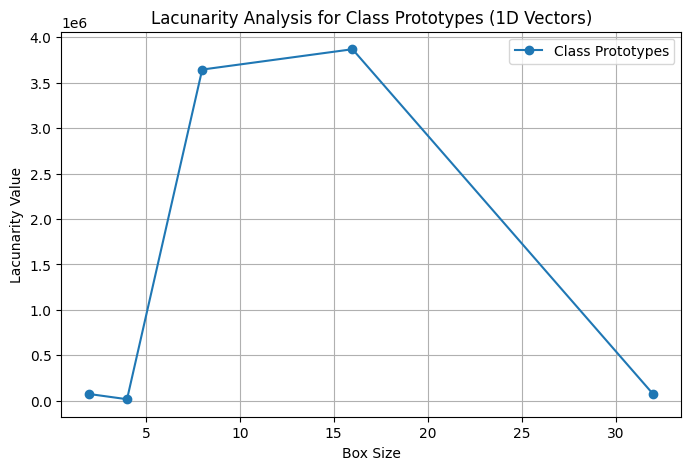

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import time
import os

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0 or var == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# ✅ Start Timer for Computational Efficiency
start_time = time.time()

# --------------------------------------------
# ✅ Spectral Feature Extractor (1D CNN)
# --------------------------------------------
# Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc = nn.Linear(256 * 204, 256)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Prototypical Network with Euclidean Distance
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "Augmented_PrototypicalNetwork_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Model successfully loaded on {device}")
# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -4].values  # Last column as true class labels

# ✅ Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# ✅ Extract Features using the trained model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()  # Convert to NumPy for classification

print("✅ Feature extraction complete. Shape:", embeddings.shape)  # Should be (22213, 128)

# ✅ Compute class prototypes (mean embeddings per class)
class_prototypes = {}
for cls in np.unique(y):
    class_indices = np.where(y == cls)[0]
    class_prototypes[cls] = embeddings[class_indices].mean(axis=0)

# ✅ Convert prototypes to tensor
prototype_array_np = np.array(list(class_prototypes.values()))  # Shape: (num_classes, 128)

# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
max_box_size = prototype_array_np.shape[1] // 2
box_sizes = [2, 4, 8, 16, 32]  # Fixed sizes
box_sizes = [b for b in box_sizes if b <= max_box_size]  # Filter valid box sizes

lacunarity_results = {"Box Size": [], "Class Prototypes": []}

# ✅ Loop through box sizes for lacunarity calculation
for box_size in box_sizes:
    print(f"✅ Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes directly as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array_np, box_size))

        # ✅ Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for Class Prototypes (1D Vectors)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")

**CAT-FSL**

✅ Model successfully loaded on cuda
✅ Feature extraction complete. Shape: (111104, 256)


0:	learn: 2.5433923	total: 16.4ms	remaining: 16.4s
50:	learn: 0.5818551	total: 670ms	remaining: 12.5s
100:	learn: 0.3639452	total: 1.29s	remaining: 11.5s
150:	learn: 0.3048277	total: 1.9s	remaining: 10.7s
200:	learn: 0.2796902	total: 2.5s	remaining: 9.93s
250:	learn: 0.2662701	total: 3.09s	remaining: 9.23s
300:	learn: 0.2560155	total: 3.69s	remaining: 8.58s
350:	learn: 0.2482309	total: 4.3s	remaining: 7.95s
400:	learn: 0.2417041	total: 4.92s	remaining: 7.34s
450:	learn: 0.2357863	total: 5.52s	remaining: 6.72s
500:	learn: 0.2306663	total: 6.12s	remaining: 6.1s
550:	learn: 0.2258976	total: 6.72s	remaining: 5.48s
600:	learn: 0.2219236	total: 7.32s	remaining: 4.86s
650:	learn: 0.2180678	total: 7.91s	remaining: 4.24s
700:	learn: 0.2147322	total: 8.51s	remaining: 3.63s
750:	learn: 0.2114841	total: 9.13s	remaining: 3.03s
800:	learn: 0.2083152	total: 9.73s	remaining: 2.42s
850:	learn: 0.2053983	total: 10.3s	remaining: 1.81s
900:	learn: 0.2026127	total: 10.9s	remaining: 1.2s
950:	learn: 0.19992

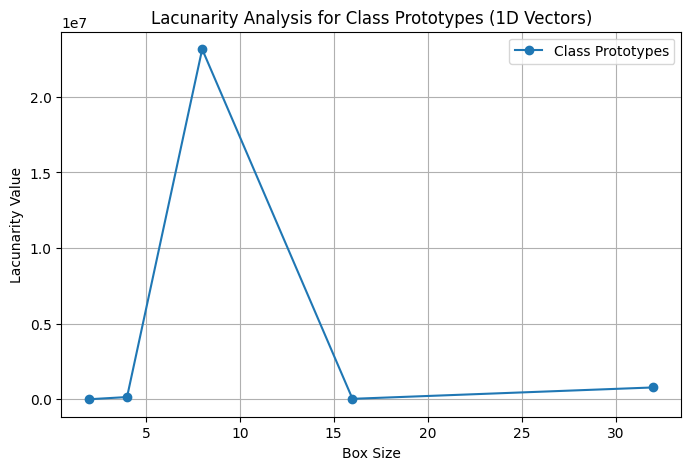

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import time
import os
from catboost import CatBoostClassifier

# ✅ Define device for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0 or var == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# ✅ Start Timer for Computational Efficiency
start_time = time.time()

# --------------------------------------------
# ✅ Spectral Feature Extractor (1D CNN)
# --------------------------------------------
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 204  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Prototypical Network for Few-Shot Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(204, 128, kernel_size=3, stride=1, padding=1),  # Changed 204 → 1
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CAT_Boost_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print(f"✅ Model successfully loaded on {device}")

# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/Salinas_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -2].values  # Last column as true class labels

# ✅ Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Convert to Tensor (Fixing Shape)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)  # Shape: (batch, 204)

# ✅ Fix: Reshape to match Conv1d input (batch, channels, spectral bands)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)  # Shape → (batch, 204, 1)

# ✅ Extract Features using Trained Model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()  # ✅ Convert to NumPy for CatBoost

print("✅ Feature extraction complete. Shape:", deep_features.shape)  # ✅ Correct variable name

# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)

catboost_model.fit(deep_features, y, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

# ✅ Compute Class Prototypes
unique_classes = np.unique(y)
class_prototypes = {}

for cls in unique_classes:
    cls_indices = np.where(y == cls)[0]
    cls_features = deep_features[cls_indices]  # ✅ Correct array indexing
    class_prototypes[cls] = np.mean(cls_features, axis=0)  # ✅ Compute mean feature for each class

# ✅ Convert Class Prototypes to Tensor
prototype_array_np = torch.tensor(np.array(list(class_prototypes.values())), dtype=torch.float32, device=device)

# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
max_box_size = prototype_array_np.shape[1] // 2
box_sizes = [2, 4, 8, 16, 32]  # Fixed sizes
box_sizes = [b for b in box_sizes if b <= max_box_size]  # Filter valid box sizes

lacunarity_results = {"Box Size": [], "Class Prototypes": []}

# ✅ Loop through box sizes for lacunarity calculation
for box_size in box_sizes:
    print(f"✅ Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes directly as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array_np.cpu().numpy(), box_size))

        # ✅ Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for Class Prototypes (1D Vectors)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")